<a href="https://colab.research.google.com/github/nishujain2203/DL-2-august-weekend/blob/main/multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
path = '/content/train_weather.csv'

In [4]:
df = pd.read_csv(path)

# basic checks

In [5]:
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season',
       'Visibility (km)', 'Location', 'Weather Type'],
      dtype='object')

In [9]:
df.isnull().sum()

,0
Temperature,0
Humidity,0
Wind Speed,0
Precipitation (%),0
Cloud Cover,0
Atmospheric Pressure,0
UV Index,0
Season,0
Visibility (km),0
Location,0


In [10]:
df.duplicated().sum()

np.int64(0)

# seperate X & Y

In [12]:
x = df.drop(['Weather Type'] , axis = 1)
y = df['Weather Type']

In [14]:
cat = x.columns[x.dtypes == 'object']
num = x.columns[x.dtypes != 'object']


# Create pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer

In [20]:
num_pipeline = Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ('Encoder' , OneHotEncoder())
])

In [18]:
# combine
pre = ColumnTransformer([
    ('num' , num_pipeline , num),
    ('cat' , cat_pipeline , cat)
])

In [25]:
x_scaled = pre.fit_transform(x)

In [27]:
pre.get_feature_names_out()
cols = []
for i in pre.get_feature_names_out():
  cols.append(i.split('_'))

In [31]:
x_scaled

array([[-0.29493119,  0.21240351, -0.04808565, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.14303484,  1.35138482, -0.19283608, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.62536707, -0.23328483, -0.40996172, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.62536707,  0.41048722, -0.62708737, ...,  1.        ,
         0.        ,  0.        ],
       [-0.92763624,  0.36096629,  0.02428956, ...,  0.        ,
         1.        ,  0.        ],
       [-1.38778537, -1.52082893, -1.42321472, ...,  0.        ,
         0.        ,  1.        ]])

In [33]:
# train test split
y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


In [34]:
y_pre = pd.get_dummies(y , dtype = 'int')

In [35]:
y_pre

,Cloudy,Rainy,Snowy,Sunny
0,0,1,0,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,1,0,0
...,...,...,...,...
13195,0,1,0,0
13196,0,0,1,0
13197,1,0,0,0
13198,0,0,1,0


In [36]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x_scaled , y_pre , test_size = 0.2 , random_state = 42)

In [37]:
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)

(10560, 18) (10560, 4)
(2640, 18) (2640, 4)


# NN Architecture and model fitting

In [38]:
from keras.models import Sequential
from keras.layers import Dense , Input


In [39]:
model = Sequential()

In [42]:
# add hidden layer
model.add(Dense(300 , activation = 'relu' , kernel_initializer= 'he_normal' , input_shape = (x_train.shape[1],)))
# add hidden layer
model.add(Dense(200 , activation = 'relu' , kernel_initializer= 'he_normal'))

# add output layer
model.add(Dense(y_train.shape[1] , activation = 'softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │         5,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,004 (613.30 KB)

 Trainable params: 157,004 (613.30 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'] )

In [45]:
#model fitting
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor= 'val_loss' , patience= 5 ,
                               verbose= 1 , restore_best_weights= True)

In [52]:
hist = model.fit(x_train , y_train , epochs = 100 , validation_split= 0.2 , batch_size= 132  ,  callbacks= early_stopping)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9591 - loss: 0.1070 - val_accuracy: 0.9394 - val_loss: 0.1395
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9613 - loss: 0.0999 - val_accuracy: 0.9370 - val_loss: 0.1482
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9661 - loss: 0.0934 - val_accuracy: 0.9342 - val_loss: 0.1581
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9725 - loss: 0.0836 - val_accuracy: 0.9313 - val_loss: 0.1580
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9738 - loss: 0.0776 - val_accuracy: 0.9347 - val_loss: 0.1659
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9766 - loss: 0.0723 - val_accuracy: 0.9304 - val_loss: 0.1798
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


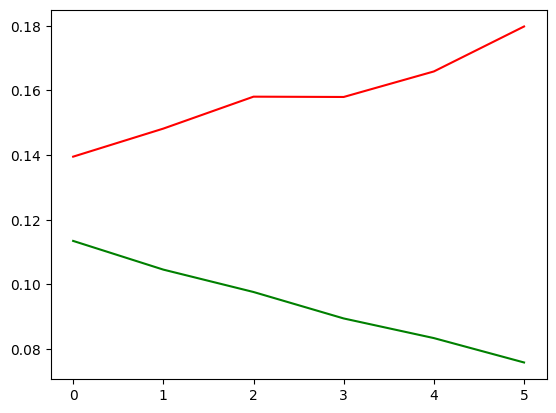

In [53]:
plt.plot(hist.history['loss'] , c = 'green')
plt.plot(hist.history['val_loss'] , c = 'red')

In [57]:
np.argmax(ytrain_pred , axis = 1)

array([1, 1, 3, ..., 0, 0, 1])

In [59]:
y_train.columns

Index(['Cloudy', 'Rainy', 'Snowy', 'Sunny'], dtype='object')

In [56]:
ytrain_pred = model.predict(x_train)

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [61]:
idx = np.argmax(ytrain_pred , axis = 1)

In [62]:
idx

array([1, 1, 3, ..., 0, 0, 1])

In [65]:
y_pred_train = [classes[i] for i in idx]

In [66]:
y_pred_train

['Rainy',
 'Rainy',
 'Sunny',
 'Rainy',
 'Cloudy',
 'Cloudy',
 'Sunny',
 'Sunny',
 'Cloudy',
 'Sunny',
 'Rainy',
 'Rainy',
 'Snowy',
 'Cloudy',
 'Snowy',
 'Snowy',
 'Cloudy',
 'Cloudy',
 'Sunny',
 'Rainy',
 'Snowy',
 'Rainy',
 'Rainy',
 'Snowy',
 'Rainy',
 'Sunny',
 'Rainy',
 'Cloudy',
 'Sunny',
 'Rainy',
 'Snowy',
 'Snowy',
 'Sunny',
 'Snowy',
 'Cloudy',
 'Rainy',
 'Cloudy',
 'Cloudy',
 'Sunny',
 'Snowy',
 'Rainy',
 'Sunny',
 'Sunny',
 'Snowy',
 'Sunny',
 'Snowy',
 'Sunny',
 'Rainy',
 'Rainy',
 'Rainy',
 'Snowy',
 'Snowy',
 'Sunny',
 'Sunny',
 'Sunny',
 'Cloudy',
 'Snowy',
 'Snowy',
 'Rainy',
 'Snowy',
 'Sunny',
 'Cloudy',
 'Sunny',
 'Snowy',
 'Sunny',
 'Rainy',
 'Snowy',
 'Cloudy',
 'Cloudy',
 'Sunny',
 'Rainy',
 'Snowy',
 'Sunny',
 'Rainy',
 'Snowy',
 'Rainy',
 'Rainy',
 'Snowy',
 'Cloudy',
 'Rainy',
 'Rainy',
 'Snowy',
 'Rainy',
 'Rainy',
 'Cloudy',
 'Cloudy',
 'Snowy',
 'Sunny',
 'Rainy',
 'Sunny',
 'Sunny',
 'Rainy',
 'Rainy',
 'Rainy',
 'Cloudy',
 'Cloudy',
 'Cloudy',
 'Rainy',


In [64]:
classes = y_train.columns.tolist()

In [67]:
y_train.head()

,Cloudy,Rainy,Snowy,Sunny
3958,0,1,0,0
2239,0,1,0,0
3608,0,0,0,1
6848,0,1,0,0
6119,1,0,0,0


In [68]:
idx2 = np.argmax(y_train , axis = 1)
y_train_actual = [classes[i] for i in idx2]

In [69]:
print(y_train_actual)

['Rainy', 'Rainy', 'Sunny', 'Rainy', 'Cloudy', 'Cloudy', 'Sunny', 'Sunny', 'Cloudy', 'Rainy', 'Rainy', 'Rainy', 'Snowy', 'Cloudy', 'Snowy', 'Snowy', 'Cloudy', 'Cloudy', 'Sunny', 'Rainy', 'Snowy', 'Rainy', 'Rainy', 'Snowy', 'Rainy', 'Sunny', 'Rainy', 'Cloudy', 'Sunny', 'Rainy', 'Snowy', 'Snowy', 'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Cloudy', 'Cloudy', 'Sunny', 'Snowy', 'Rainy', 'Sunny', 'Sunny', 'Snowy', 'Sunny', 'Cloudy', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Snowy', 'Snowy', 'Sunny', 'Sunny', 'Sunny', 'Cloudy', 'Snowy', 'Snowy', 'Rainy', 'Snowy', 'Sunny', 'Cloudy', 'Sunny', 'Snowy', 'Sunny', 'Rainy', 'Snowy', 'Cloudy', 'Cloudy', 'Sunny', 'Rainy', 'Snowy', 'Sunny', 'Rainy', 'Snowy', 'Rainy', 'Rainy', 'Snowy', 'Cloudy', 'Snowy', 'Rainy', 'Snowy', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Snowy', 'Sunny', 'Rainy', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Snowy', 'Snowy', 'Rainy', 'Sunny', 'Snowy', 'Snowy', 'Cloudy', 'Cloudy', 'Snowy', 'Snowy', 'Rai

In [70]:
# evaluate model
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report

In [71]:
print(confusion_matrix(y_train_actual , y_pred_train))
print(classification_report(y_train_actual , y_pred_train))

[[2489  123   12   25]
 [  31 2581   19   22]
 [  28   59 2496   16]
 [  31   53   21 2554]]
              precision    recall  f1-score   support

      Cloudy       0.97      0.94      0.95      2649
       Rainy       0.92      0.97      0.94      2653
       Snowy       0.98      0.96      0.97      2599
       Sunny       0.98      0.96      0.97      2659

    accuracy                           0.96     10560
   macro avg       0.96      0.96      0.96     10560
weighted avg       0.96      0.96      0.96     10560



# testing evaluation

In [72]:
idx3 = np.argmax(y_test , axis = 1)
y_test_actual = [classes[i] for i in idx2]

In [73]:
ypred = model.predict(x_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [74]:
idx4 = np.argmax(ypred , axis = 1)
y_test_actual = [classes[i] for i in idx4]

In [78]:
print(y_test_actual)
print(y_test_pred)

['Sunny', 'Sunny', 'Sunny', 'Snowy', 'Sunny', 'Snowy', 'Sunny', 'Rainy', 'Sunny', 'Snowy', 'Snowy', 'Snowy', 'Snowy', 'Sunny', 'Sunny', 'Sunny', 'Rainy', 'Sunny', 'Sunny', 'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Sunny', 'Snowy', 'Sunny', 'Cloudy', 'Snowy', 'Cloudy', 'Snowy', 'Sunny', 'Rainy', 'Snowy', 'Sunny', 'Rainy', 'Snowy', 'Snowy', 'Cloudy', 'Rainy', 'Sunny', 'Cloudy', 'Cloudy', 'Snowy', 'Rainy', 'Snowy', 'Sunny', 'Sunny', 'Cloudy', 'Rainy', 'Snowy', 'Sunny', 'Rainy', 'Snowy', 'Snowy', 'Snowy', 'Sunny', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Sunny', 'Rainy', 'Sunny', 'Sunny', 'Snowy', 'Rainy', 'Rainy', 'Cloudy', 'Rainy', 'Sunny', 'Snowy', 'Snowy', 'Rainy', 'Rainy', 'Snowy', 'Rainy', 'Snowy', 'Cloudy', 'Rainy', 'Sunny', 'Cloudy', 'Sunny', 'Cloudy', 'Snowy', 'Rainy', 'Sunny', 'Snowy', 'Sunny', 'Cloudy', 'Cloudy', 'Snowy', 'Cloudy', 'Snowy', 'Snowy', 'Rainy', 'Snowy', 'Snowy', 'Rainy', 'Rainy', 'Cloudy', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Cloudy', 'Rainy', 'Cloudy', 'Cloudy', 'Cl

In [76]:
ypred = model.predict(x_test)
idx4 = np.argmax(ypred , axis = 1)
y_test_pred = [classes[i] for i in idx4]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [77]:
idx3 = np.argmax(y_test , axis = 1)
y_test_actual = [classes[i] for i in idx3]

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test_actual , y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test_actual , y_test_pred))

Confusion Matrix (Test Set):
[[574  45  10  22]
 [ 28 598  12   9]
 [  4  23 659  15]
 [ 33  30  10 568]]

Classification Report (Test Set):
              precision    recall  f1-score   support

      Cloudy       0.90      0.88      0.89       651
       Rainy       0.86      0.92      0.89       647
       Snowy       0.95      0.94      0.95       701
       Sunny       0.93      0.89      0.91       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



In [80]:
print(confusion_matrix(y_test_actual , y_test_pred))
print(accuracy_score(y_test_actual , y_test_pred))
print(classification_report(y_test_actual , y_test_pred))

[[574  45  10  22]
 [ 28 598  12   9]
 [  4  23 659  15]
 [ 33  30  10 568]]
0.9087121212121212
              precision    recall  f1-score   support

      Cloudy       0.90      0.88      0.89       651
       Rainy       0.86      0.92      0.89       647
       Snowy       0.95      0.94      0.95       701
       Sunny       0.93      0.89      0.91       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



In [85]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 Index(['Cloud Cover', 'Season', 'Location'], dtype='object'))])

In [81]:
testpath = '/content/test_weather.csv'

In [82]:
test = pd.read_csv(testpath)

In [83]:
test_x = pre.fit_transform(test)

In [86]:
test_x = pd.DataFrame(test_x )

In [87]:
pred = model.predict(test_x)
idx5 = np.argmax(pred , axis = 1)
y_test_pred = [classes[i] for i in idx5]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [88]:
print(y_test_pred)

['Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Sunny', 'Cloudy', 'Snowy', 'Snowy', 'Snowy', 'Sunny', 'Rainy', 'Rainy', 'Snowy', 'Cloudy', 'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Snowy', 'Snowy', 'Rainy', 'Rainy', 'Cloudy', 'Rainy', 'Snowy', 'Snowy', 'Cloudy', 'Cloudy', 'Rainy', 'Snowy', 'Sunny', 'Cloudy', 'Snowy', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Cloudy', 'Snowy', 'Cloudy', 'Snowy', 'Snowy', 'Cloudy', 'Rainy', 'Snowy', 'Cloudy', 'Snowy', 'Sunny', 'Sunny', 'Cloudy', 'Rainy', 'Rainy', 'Sunny', 'Rainy', 'Sunny', 'Cloudy', 'Rainy', 'Rainy', 'Sunny', 'Snowy', 'Sunny', 'Cloudy', 'Snowy', 'Sunny', 'Snowy', 'Cloudy', 'Rainy', 'Snowy', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Rainy', 'Cloudy', 'Cloudy', 'Snowy', 'Snowy', 'Rainy', 'Rainy', 'Rainy', 'Snowy', 'Sunny', 'Cloudy', 'Cloudy', 'Snowy', 'Sunny', 'Sunny', 'Snowy', 'Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Snowy', 'Sunny', 'Cloudy']
